# Problem 1: Bag-of-Words Feature Representation
In this notebook, we will explore the concept of the Bag-of-Words (BoW) representation for text data and its two popular variations:


In [93]:
# Import necessary libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
x_train_df = pd.read_csv('../data_reviews/x_train.csv')
y_train_df = pd.read_csv('../data_reviews/y_train.csv')

# Convert the columns to lists/arrays
x_train_unshuffled = x_train_df['text'].values.tolist()
y = y_train_df['is_positive_sentiment'].values

# Shuffle both X and y together
X_train, y_train = shuffle(x_train_unshuffled, y, random_state=42)

# Check the lengths
print(f'Length of tr_list_of_sentences: {len(x_train_unshuffled)}')
print(f'Length of y_train: {len(y)}')

Length of tr_list_of_sentences: 2400
Length of y_train: 2400


To process the training data, we will remove all the stop words and punctuations using the CountVectorizer method from the scikit-learn library. We will also use the same CountVectorizer method to transform the test data. We will also be using the unigram method to help us understand the concept of BoW representation better and excclude words that appear in less than 5 documents.

In [95]:
# Creating the pipeline
vectorizer = CountVectorizer(ngram_range=(1, 1))

# Fit the vectorizer to the data
X = vectorizer.fit_transform(X_train)  # 'documents' is your input text data

# Print the size of the vocabulary
print("Vocabulary size:", len(vectorizer.vocabulary_))

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True, sublinear_tf=True)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

Vocabulary size: 4510


For the hyperparameter tuning, we will use the GridSearchCV method from the scikit-learn library to find the best hyperparameters for the Logistic Regression model. We will also use the accuracy score to evaluate the model's performance. We also use two different logistic regressions models(one based on quasi-newton method and other based on stochastic gradient descent) to compare the performance of the two models.

In [98]:
param_grid = {
    'classifier__solver': ['lbfgs', 'saga'],
    'vectorizer__max_features': [100, 500, 1000, 10000, 100000],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet']
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc'
)


grid_search.fit(X_train, y_train)



/Users/manuelpena/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/manuelpena/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/manuelpena/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/manuelpena/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/manuelpena/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('tfidf',
                                        TfidfTransformer(sublinear_tf=True)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                         'classifier__solver': ['lbfgs', 'saga'],
                         'vectorizer__max_features': [100, 500, 1000, 10000,
                                                      100000]},
             scoring='roc_auc')

In [99]:
# Retrieve the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation AUC: ", grid_search.best_score_)

# # Use the best estimator from GridSearchCV to make predictions
best_svc = grid_search.best_estimator_

# LEADERBOARD: 0.91283  postion 5

Best parameters found:  {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'vectorizer__max_features': 100000}
Best cross-validation AUC:  0.9017291666666667


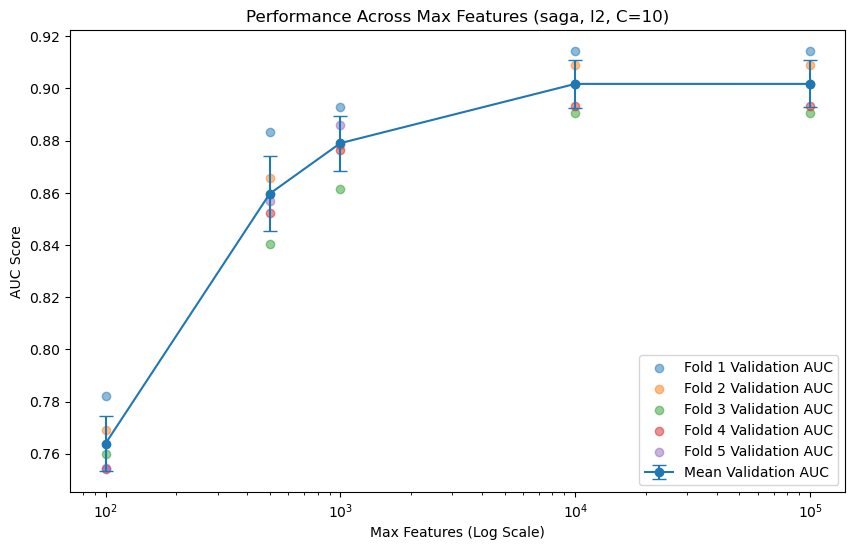

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Extract max_features values from the parameter grid
max_features_values = param_grid['vectorizer__max_features']

# Filter the cv_results_ for solver='lbfgs', penalty='l2', and C=1 to isolate max_features
mask = (grid_search.cv_results_['param_classifier__solver'] == 'saga') & \
       (grid_search.cv_results_['param_classifier__penalty'] == 'l2') & \
       (grid_search.cv_results_['param_classifier__C'] == 10)

# Apply the mask to get the relevant test scores
test_scores_mean = grid_search.cv_results_['mean_test_score'][mask]
test_scores_std = grid_search.cv_results_['std_test_score'][mask]

# Extract the individual split test scores (validation scores for each fold)
splits = 5  # Number of CV splits
test_scores_per_fold = []

for i in range(splits):
    test_scores_per_fold.append(grid_search.cv_results_[f'split{i}_test_score'][mask])

# Convert test scores to a NumPy array for easy plotting
test_scores_per_fold = np.array(test_scores_per_fold)

# Create the plot for max_features
plt.figure(figsize=(10, 6))

# Plot the mean validation scores with error bars
plt.errorbar(max_features_values, test_scores_mean, yerr=test_scores_std, label='Mean Validation AUC', fmt='o-', capsize=5)

# Add individual points for each fold's performance
for i in range(splits):
    plt.scatter(max_features_values, test_scores_per_fold[i], label=f'Fold {i+1} Validation AUC', alpha=0.5)

# Add labels, title, legend
plt.xscale('log')  # Logarithmic scale for max_features
plt.xlabel('Max Features (Log Scale)')
plt.ylabel('AUC Score')
plt.title('Performance Across Max Features (saga, l2, C=10)')
plt.legend(loc='best')

# Show plot
plt.show()

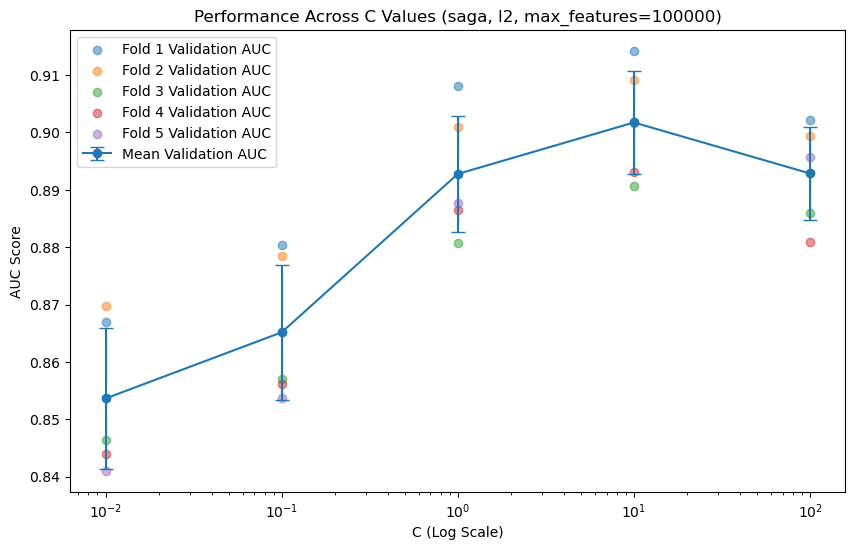

In [116]:
# Extract C values from the parameter grid
C_values = param_grid['classifier__C']

# Filter the cv_results_ for solver='lbfgs', penalty='l2', and max_features=1000 to isolate C values
mask = (grid_search.cv_results_['param_classifier__solver'] == 'saga') & \
       (grid_search.cv_results_['param_classifier__penalty'] == 'l2') & \
       (grid_search.cv_results_['param_vectorizer__max_features'] == 100000)

# Apply the mask to get the relevant test scores
test_scores_mean = grid_search.cv_results_['mean_test_score'][mask]
test_scores_std = grid_search.cv_results_['std_test_score'][mask]

# Extract the individual split test scores (validation scores for each fold)
test_scores_per_fold = []
for i in range(splits):
    test_scores_per_fold.append(grid_search.cv_results_[f'split{i}_test_score'][mask])

# Convert test scores to a NumPy array for easy plotting
test_scores_per_fold = np.array(test_scores_per_fold)

# Create the plot for C values
plt.figure(figsize=(10, 6))

# Plot the mean validation scores with error bars
plt.errorbar(C_values, test_scores_mean, yerr=test_scores_std, label='Mean Validation AUC', fmt='o-', capsize=5)

# Add individual points for each fold's performance
for i in range(splits):
    plt.scatter(C_values, test_scores_per_fold[i], label=f'Fold {i+1} Validation AUC', alpha=0.5)

# Add labels, title, legend
plt.xscale('log')  # Logarithmic scale for C values
plt.xlabel('C (Log Scale)')
plt.ylabel('AUC Score')
plt.title('Performance Across C Values (saga, l2, max_features=100000)')
plt.legend(loc='best')

# Show plot
plt.show()


In [92]:
y_pred = grid_search.best_estimator_.predict(X_train)

print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

y_pred_prob = grid_search.best_estimator_.predict_proba(X_train)[:, 1]

auc = roc_auc_score(y_train, y_pred_prob)

print(f'AUC: {auc:.4f}')

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1200
           1       1.00      0.99      0.99      1200

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400

[[1196    4]
 [  15 1185]]
AUC: 0.9987


In [101]:
# Create a DataFrame for analysis
results_df = pd.DataFrame({
    'True': y_train,      # True labels
    'Predicted': y_pred,  # Predicted labels
    'Review': X_train     # Assuming X_train contains review texts
})

# Identify false positives and false negatives
false_positives = results_df[(results_df['True'] == 0) & (results_df['Predicted'] == 1)]
false_negatives = results_df[(results_df['True'] == 1) & (results_df['Predicted'] == 0)]

# Display examples of false positives and false negatives
print("False Positives:")
print(false_positives[['Review', 'True', 'Predicted']].head(5))  # Show first 5 examples

print("\nFalse Negatives:")
print(false_negatives[['Review', 'True', 'Predicted']].head(5))  # Show first 5 examples


False Positives:
                                                 Review  True  Predicted
882   I really wanted the Plantronics 510 to be the ...     0          1
1570  If you plan to use this in a car forget about it.     0          1
2075  The only place good for this film is in the ga...     0          1
2304  Graphics is far from the best part of the game.       0          1

False Negatives:
                                                Review  True  Predicted
76                   It was just not a fun experience.     1          0
121  Not too screamy not to masculine but just righ...     1          0
633                         You won't be disappointed.     1          0
868                   Waste your money on this game.       1          0
889  The last 15 minutes of movie are also not bad ...     1          0


In [85]:
# Load the test data
x_test_df = pd.read_csv('../data_reviews/x_test.csv')

# Get the predicted probabilities for the positive class
y_test_pred_prob = grid_search.best_estimator_.predict_proba(x_test_df['text'])[:, 1]

# Save the probabilities to a plain-text file
with open('../data_reviews/yproba1_test.txt', 'w') as f:
    for prob in y_test_pred_prob:
        f.write(f"{prob:.6f}\n")  # Formatting to six decimal places

print("Probabilistic predictions saved to '../data_reviews/yproba1_test.txt'.")

Probabilistic predictions saved to '../data_reviews/yproba1_test.txt'.
